In [ ]:
from keras.utils import get_file
import tarfile
data_dir = get_file('aclImdb_v1.tar.gz', 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz', cache_subdir = "datasets",hash_algorithm = "auto", extract = True, archive_format = "auto")

my_tar = tarfile.open(data_dir)
my_tar.extractall('./data/') # specify which folder to extract to
my_tar.close()

Using TensorFlow backend.


84131840/84125825 [==============================] - 5s 0us/step


In [ ]:
from glob import glob
import os,re,string
import numpy as np
PATH='./data/aclImdb/'
names = ['neg','pos']

def load_texts_labels_from_folders(path, folders):
    texts,labels = [],[]
    for idx,label in enumerate(folders):
        for fname in glob(os.path.join(path, label, '*.*')):
            texts.append(open(fname, 'r').read())
            labels.append(idx)
    
    return texts, np.array(labels).astype(np.int64)

x_train,y_train = load_texts_labels_from_folders(f'{PATH}train',names)
x_test,y_test = load_texts_labels_from_folders(f'{PATH}test',names)




In [ ]:


def preprocess_reviews(reviews):
    tokens = re.compile("[.;:!#\'?,\"()\[\]]|(<br\s*/><br\s*/>)|(\-)|(\/)")
    
    return [tokens.sub("", line.lower()) for line in reviews]

x_train_clean = preprocess_reviews(x_train)
x_test_clean = preprocess_reviews(x_test)

In [ ]:
x_train_clean[7]

'i had high expectations for this indie having perused the many thumbs up reviews thenheres my additional two cents to the already posted excellent lost in translation review premise morgan is stuck in a dusty small town where he meets lovely scarlet who is working in the local supermarket can morgan help elevate the lovely scarlet from her trailer trash liferealistic dialog not how about that shopping in target first freeman looks at the target interior as if hes walked into harrods then hes bowled over at a tshirt rack confirming he has never been in any store visited by lovely scarlet morgan is detached from any and all aspects of scarlets reality and is portrayed as gleeful in his ignorance of everyone and everything in scarlets lifeone reviewer enjoyed the scarlet and exhubby fight scene where her survival a car in this instance requires she physically attack her ex hubbie does freeman run to her defensenawhes cowering in disbelief and totally incapable of dealing with such a blun

In [ ]:
y_train

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
import tensorflow as tf
from tensorflow import keras
tok = keras.preprocessing.text.Tokenizer()
tok.fit_on_texts(x_train_clean) 
X_train = tok.texts_to_sequences(x_train_clean)
X_test = tok.texts_to_sequences(x_test_clean)

#" ".join(map(str,X_train[0]))

In [ ]:
lengths = [len(i) for i in X_train]
print(f'Max length of sentence: {max(lengths)}')
print(f'Average length of sentence: {np.mean(lengths)}')

Max length of sentence: 2451
Average length of sentence: 228.8952


In [ ]:
from sklearn.model_selection import train_test_split
X_train = keras.preprocessing.sequence.pad_sequences(X_train,padding='post',maxlen=1000)
X_test = keras.preprocessing.sequence.pad_sequences(X_test,padding='post',maxlen=1000)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
# X_train[7]

In [ ]:
# build model
# input shape is the vocabulary count used for the movie reviews (10,000 words)
vocab_size = len(tok.word_index)+1

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Conv1D(filters=16,kernel_size=2,padding='valid',activation='relu'))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          2284368   
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          528       
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                544       
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

In [ ]:
history = model.fit(X_train,y_train,
                    epochs=20,
                    validation_data=(X_val, y_val),
                    verbose=1, # print result every epoch
                    batch_size=512)

Epoch 1/20
35/35 [==============================] - 11s 318ms/step - loss: 0.6931 - acc: 0.5043 - val_loss: 0.6927 - val_acc: 0.5068
Epoch 2/20
35/35 [==============================] - 10s 291ms/step - loss: 0.6918 - acc: 0.5480 - val_loss: 0.6899 - val_acc: 0.5944
Epoch 3/20
35/35 [==============================] - 10s 289ms/step - loss: 0.6862 - acc: 0.5946 - val_loss: 0.6782 - val_acc: 0.6297
Epoch 4/20
35/35 [==============================] - 10s 284ms/step - loss: 0.6636 - acc: 0.6693 - val_loss: 0.6389 - val_acc: 0.7519
Epoch 5/20
35/35 [==============================] - 10s 286ms/step - loss: 0.6021 - acc: 0.7669 - val_loss: 0.5562 - val_acc: 0.8055
Epoch 6/20
35/35 [==============================] - 10s 294ms/step - loss: 0.5069 - acc: 0.8141 - val_loss: 0.4609 - val_acc: 0.8457
Epoch 7/20
35/35 [==============================] - 11s 301ms/step - loss: 0.4165 - acc: 0.8520 - val_loss: 0.3905 - val_acc: 0.8651
Epoch 8/20
35/35 [==============================] - 10s 296ms/step - 

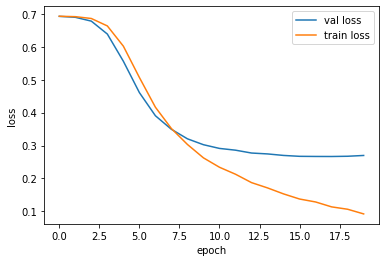

In [ ]:
import matplotlib.pyplot as plt
def plot_loss(history):
  plt.plot(history.history['val_loss'],label="val loss")
  plt.plot(history.history['loss'],label="train loss")
  plt.xlabel('epoch')
  plt.ylabel('loss')

  plt.legend()
  plt.show()

plot_loss(history)

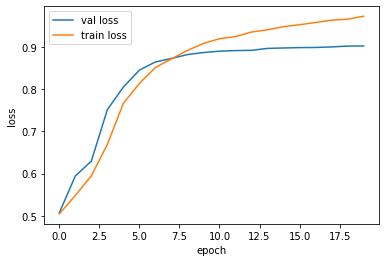

In [ ]:
import matplotlib.pyplot as plt
def plot_loss(history):
  plt.plot(history.history['val_acc'],label="val loss")
  plt.plot(history.history['acc'],label="train loss")
  plt.xlabel('epoch')
  plt.ylabel('loss')

  plt.legend()
  plt.show()

plot_loss(history)

In [ ]:
%pwd
%cd /content/drive/My Drive/assignment3/

/content/drive/My Drive/assignment3


In [ ]:
model.save("./models/20834941_NLP_model.h5")